<a href="https://colab.research.google.com/github/eylulpelinkilic/Clash-Royale-DSA210-Project/blob/main/FINAL_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Find the top 5 most used team decks
top_5_decks = df['team_deck'].value_counts().nlargest(5).index.tolist()

# Create a mapping dictionary for deck names
deck_name_map = {deck: f'deck{i}' for i, deck in enumerate(top_5_decks)}

# Add a new column: team_deck_name
# If team_deck is in the top 5, assign deck0 to deck4; otherwise assign 'other'
df['team_deck_name'] = df['team_deck'].apply(lambda x: deck_name_map.get(x, 'other'))

# Team deck'teki farklı kart tipi sayısı (her maç için)
df['team_cardtype_variety'] = (df[[col for col in df.columns if col.startswith('team_n_')]] > 0).sum(axis=1)

df.to_excel("matches_50_players_prep.xlsx", index=False)
from google.colab import files
files.download("matches_50_players_prep.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("matches_50_players_prep.xlsx")

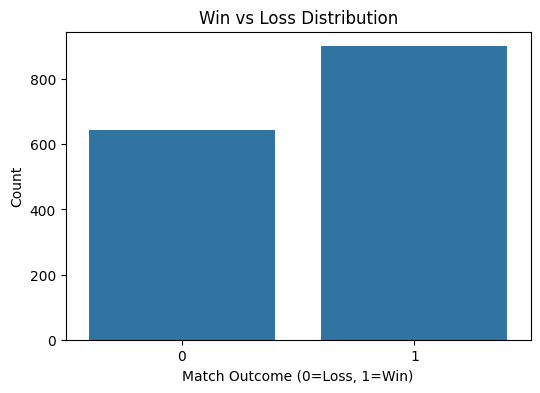

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='win', data=df)
plt.title('Win vs Loss Distribution')
plt.xlabel('Match Outcome (0=Loss, 1=Win)')
plt.ylabel('Count')
plt.show()

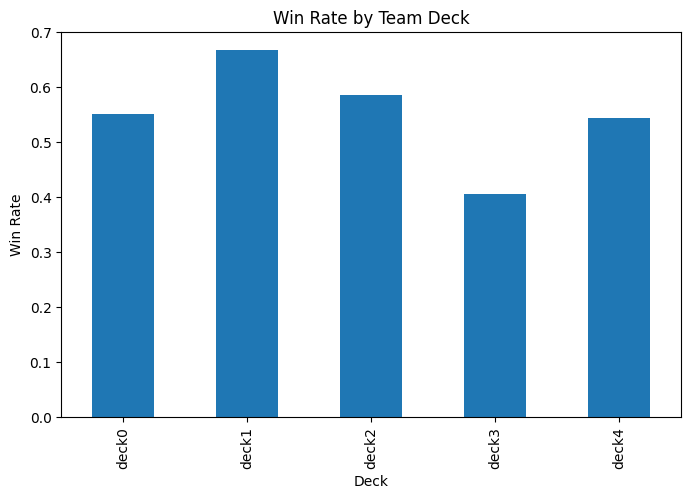

In [9]:
deck_win_rates = df.groupby('team_deck_name')['win'].mean().loc[['deck0','deck1','deck2','deck3','deck4']]

plt.figure(figsize=(8,5))
deck_win_rates.plot(kind='bar')
plt.title('Win Rate by Team Deck')
plt.ylabel('Win Rate')
plt.xlabel('Deck')
plt.show()


<ipython-input-21-8688a1f90c3e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Win_Rate', y='Card', data=win_rate_df, palette='viridis')


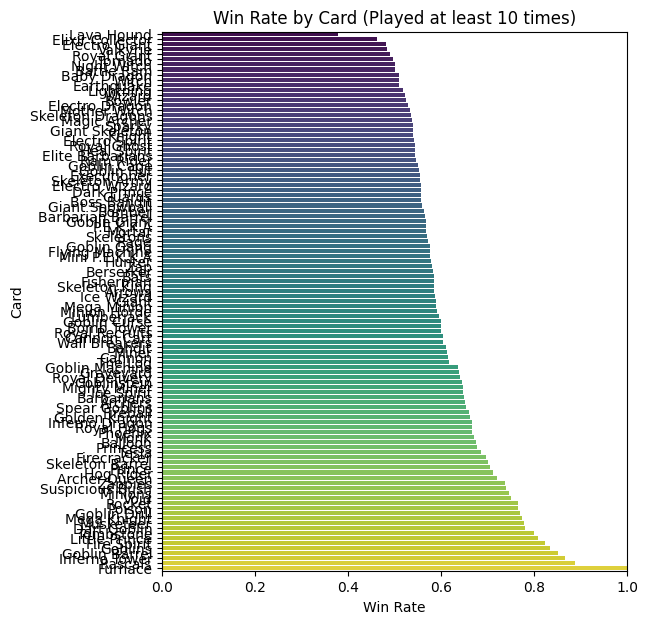

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Find all team card columns
card_columns = [col for col in df.columns if col.startswith('team_has_')]

# Calculate win rates per card
win_rates = []
for card_col in card_columns:
    card_matches = df[df[card_col] == 1]
    win_rate = card_matches['win'].mean()
    card_name = card_col.replace('team_has_', '')
    win_rates.append({'Card': card_name, 'Win_Rate': win_rate})

win_rate_df = pd.DataFrame(win_rates)

# Filter cards that have been played at least some threshold (e.g., 10 matches) to avoid bias from rare cards
min_played = 10
win_rate_df['Play_Count'] = win_rate_df['Card'].apply(lambda c: df[f'team_has_{c}'].sum())
win_rate_df = win_rate_df[win_rate_df['Play_Count'] >= min_played]

# Sort by win rate descending
win_rate_df = win_rate_df.sort_values(by='Win_Rate', ascending=True)  # ascending for better horizontal barplot

# Plot horizontal bar plot
plt.figure(figsize=(6, 7))
sns.barplot(x='Win_Rate', y='Card', data=win_rate_df, palette='viridis')
plt.xlabel('Win Rate')
plt.ylabel('Card')
plt.title('Win Rate by Card (Played at least 10 times)')
plt.xlim(0, 1)
plt.show()


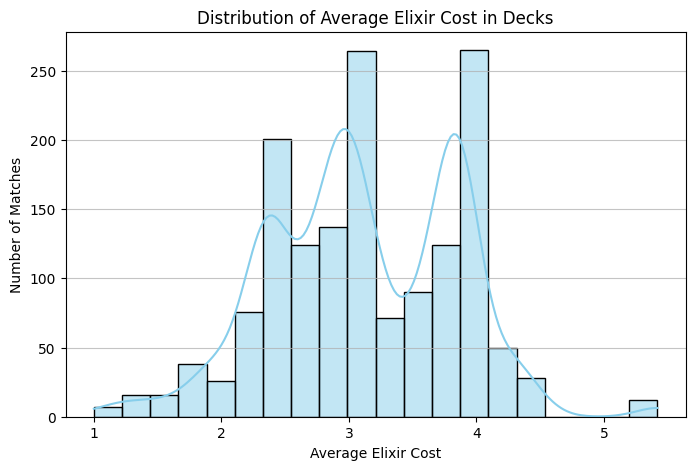

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['team_avg_elixir'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Elixir Cost in Decks')
plt.xlabel('Average Elixir Cost')
plt.ylabel('Number of Matches')
plt.grid(axis='y', alpha=0.75)
plt.show()


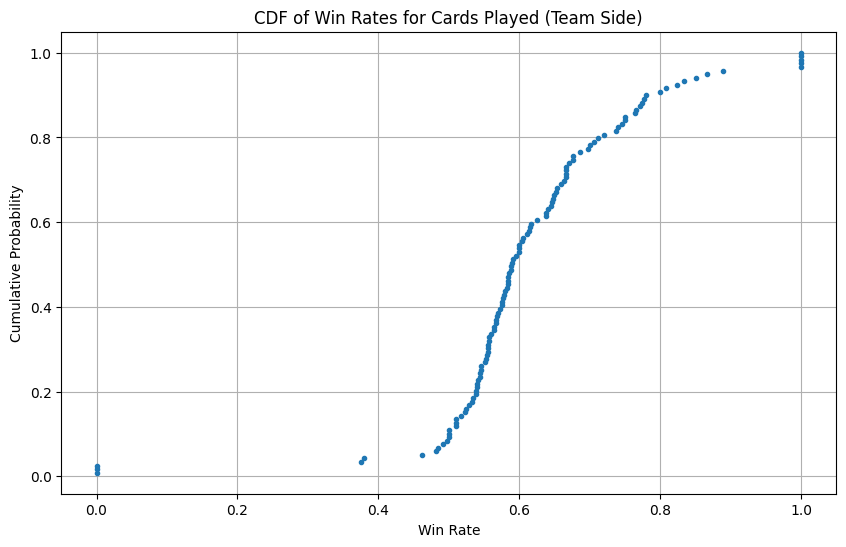

In [46]:
import numpy as np
import matplotlib.pyplot as plt

cards = [col for col in df.columns if col.startswith('team_has_')]
win_rates = []

for card in cards:
    # Kartı oynayan maçları seç (1 olanlar)
    played = df[df[card] == 1]
    if len(played) > 0:
        win_rate = played['win'].mean()
        win_rates.append((card, win_rate))

# Kartları ve win_rate'leri ayır
cards_names, rates = zip(*win_rates)

# Win rate'leri sıralı hale getir
sorted_rates = np.sort(rates)

# CDF hesapla
cdf = np.arange(1, len(sorted_rates) + 1) / len(sorted_rates)

plt.figure(figsize=(10,6))
plt.plot(sorted_rates, cdf, marker='.', linestyle='none')
plt.xlabel('Win Rate')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Win Rates for Cards Played (Team Side)')
plt.grid(True)
plt.show()


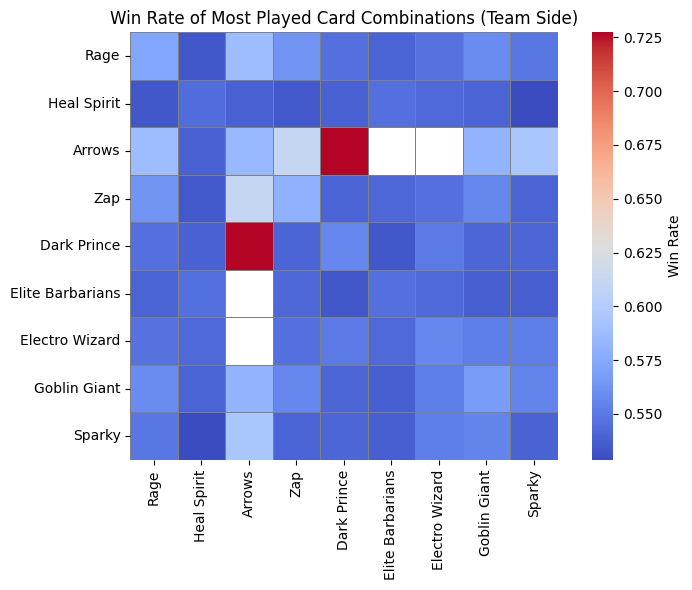

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Takım kart kolonlarını seç
team_card_cols = [col for col in df.columns if col.startswith('team_has_')]

# 2. Kart isimlerini çıkar (team_has_ kısmını çıkar)
cards = [col.replace('team_has_', '') for col in team_card_cols]

# 3. Kart çiftlerinin birlikte oynanma sayısını hesapla
from itertools import combinations

pair_counts = {}

for c1, c2 in combinations(team_card_cols, 2):
    count = ((df[c1] == 1) & (df[c2] == 1)).sum()
    pair_counts[(c1, c2)] = count

# 4. En çok birlikte oynanmış 20 kart çifti seç
top_20_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# 5. Bu çiftlerdeki kart isimlerini al, tekrar edenleri ayıkla
top_20_cards = set()
for (c1, c2), count in top_20_pairs:
    top_20_cards.add(c1.replace('team_has_', ''))
    top_20_cards.add(c2.replace('team_has_', ''))

top_20_cards = list(top_20_cards)

# 6. Bu kartlar için kazanma oranı matrisi oluştur
combo_win_rates = pd.DataFrame(index=top_20_cards, columns=top_20_cards, dtype=float)

for card1 in top_20_cards:
    for card2 in top_20_cards:
        col1 = f'team_has_{card1}'
        col2 = f'team_has_{card2}'
        if col1 in df.columns and col2 in df.columns:
            filtered = df[(df[col1] == 1) & (df[col2] == 1)]
            if len(filtered) >= 5:  # en az 5 maç olmalı
                combo_win_rates.loc[card1, card2] = filtered['win'].mean()
            else:
                combo_win_rates.loc[card1, card2] = np.nan

# 7. NaN değerler için mask oluştur
mask = combo_win_rates.isnull()

# 8. Heatmap çizimi
plt.figure(figsize=(8,6))
sns.heatmap(combo_win_rates, cmap='coolwarm', annot=False, square=True, mask=mask,
            cbar_kws={'label': 'Win Rate'}, linewidths=0.5, linecolor='gray')

plt.title('Win Rate of Most Played Card Combinations (Team Side)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


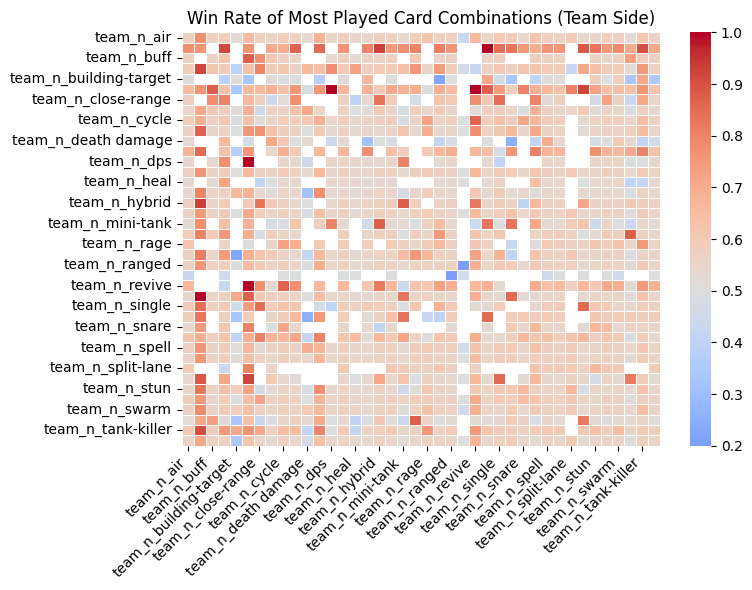

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# varsayalım df hazır ve card type sütunları "team_n_*" şeklinde

# 1. Card type sütunlarını seç (team tarafı)
team_type_cols = [col for col in df.columns if col.startswith('team_n_')]

# 2. İkili kombinasyonları oluştur
type_pairs = list(itertools.combinations(team_type_cols, 2))

# 3. Her kombinasyon için birlikte en az 5 maç oynanmış olanları filtrele ve win rate hesapla
results = {}
for t1, t2 in type_pairs:
    mask = (df[t1] > 0) & (df[t2] > 0)  # ikisi de oynanmış
    if mask.sum() >= 5:
        win_rate = df.loc[mask, 'win'].mean()
        results[(t1, t2)] = win_rate

# 4. Sonuçları DataFrame’e çevir
pairs = list(results.keys())
win_rates = list(results.values())

# 5. Matris oluşturmak için boş DataFrame
unique_types = sorted(set([item for sublist in pairs for item in sublist]))
heatmap_matrix = pd.DataFrame(np.nan, index=unique_types, columns=unique_types)

# 6. Matrise değerleri yerleştir
for (t1, t2), rate in results.items():
    heatmap_matrix.loc[t1, t2] = rate
    heatmap_matrix.loc[t2, t1] = rate

# 7. Diagonal'ı win rate ile doldurabiliriz (örneğin tek tipli maçların ortalama kazanma oranı)
for t in unique_types:
    mask = df[t] > 0
    if mask.sum() >= 5:
        heatmap_matrix.loc[t, t] = df.loc[mask, 'win'].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=False, cmap="coolwarm", center=0.5, linewidths=0.5)
plt.title("Win Rate of Most Played Card Combinations (Team Side)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



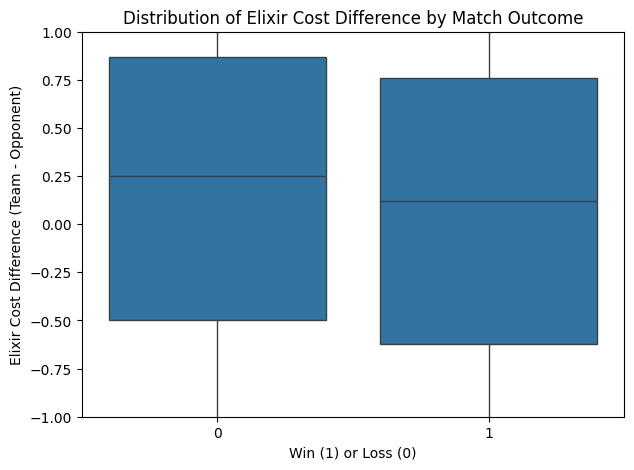

In [11]:
plt.figure(figsize=(7,5))
sns.boxplot(x='win', y='diff_avg_elixir', data=df)
plt.title('Distribution of Elixir Cost Difference by Match Outcome')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Elixir Cost Difference (Team - Opponent)')
plt.ylim(-1, 1)
plt.show()


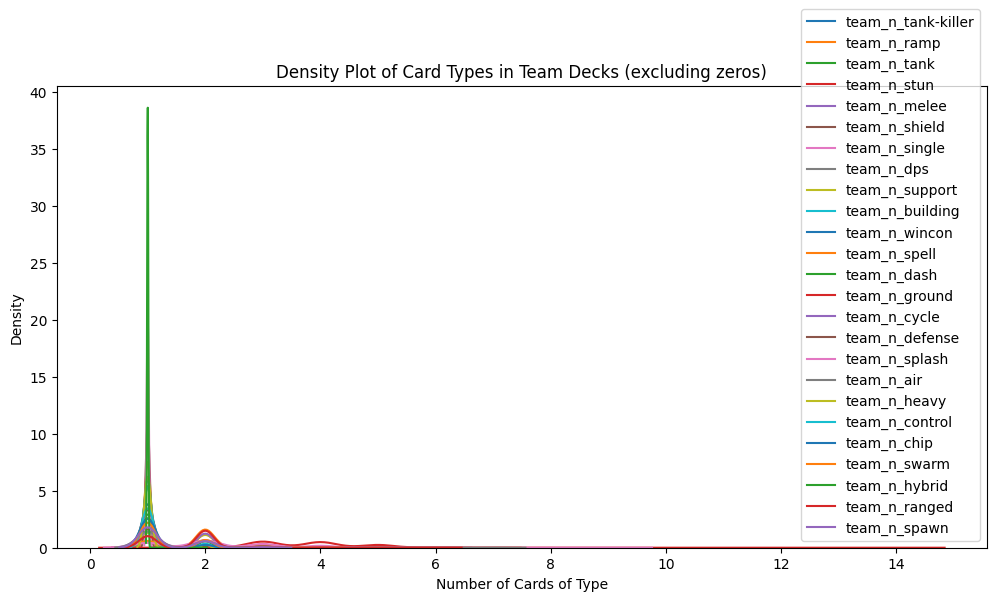

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

card_type_cols = [col for col in df.columns if col.startswith('team_n_')]

plt.figure(figsize=(12, 6))

for col in card_type_cols:
    data = df.loc[df[col] > 0, col]
    if data.nunique() > 1:  # Değişkenlik varsa çiz
        sns.kdeplot(data, label=col)

plt.title('Density Plot of Card Types in Team Decks (excluding zeros)')
plt.xlabel('Number of Cards of Type')
plt.ylabel('Density')
plt.legend()
plt.show()


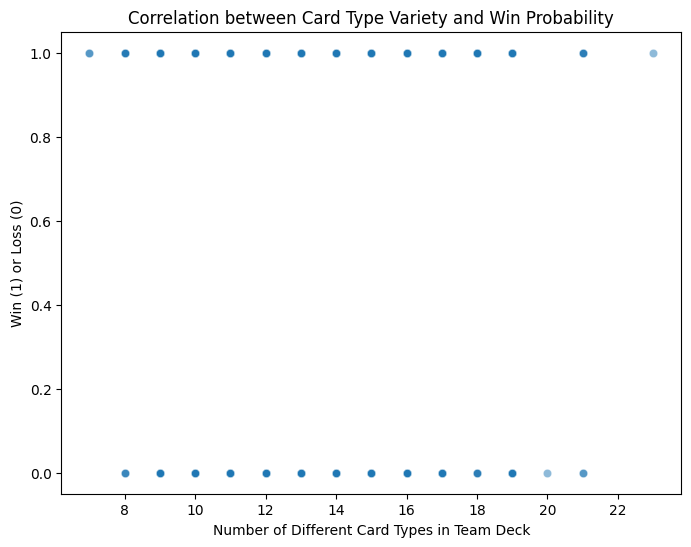

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("matches_50_players_prep (2).xlsx")



plt.figure(figsize=(8,6))
sns.scatterplot(x='team_cardtype_variety', y='win', data=df, alpha=0.5)
plt.title('Correlation between Card Type Variety and Win Probability')
plt.xlabel('Number of Different Card Types in Team Deck')
plt.ylabel('Win (1) or Loss (0)')
plt.show()


Correlation between card type variety and win rate: -0.165


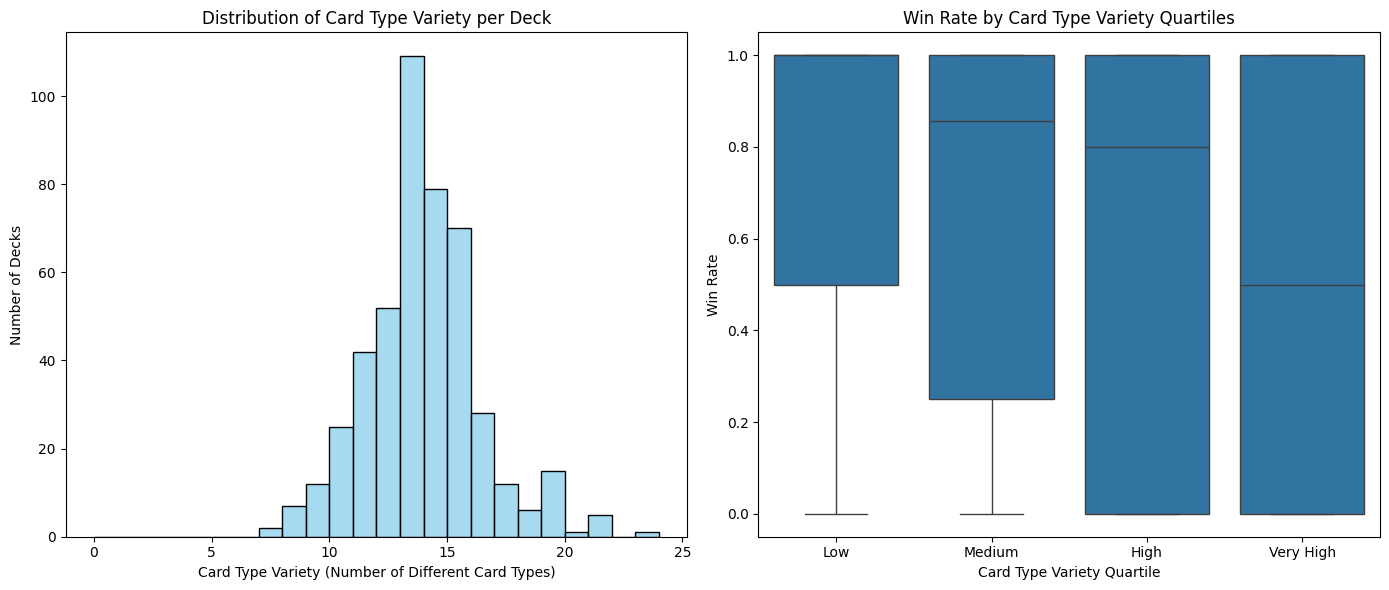

NameError: name 'df_deckstats' is not defined

<Figure size 800x600 with 0 Axes>

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Her deck için toplam maç sayısı ve kazanma sayısı
deck_stats = df.groupby('team_deck').agg(
    total_matches=('win', 'count'),
    wins=('win', 'sum')
).reset_index()

# 2. Win rate hesapla
deck_stats['win_rate'] = deck_stats['wins'] / deck_stats['total_matches']

# 3. Kart tipi kolonlarını seç (team_n_ ile başlayanlar)
card_type_cols = [col for col in df.columns if col.startswith('team_n_')]

# 4. Her deck için ortalama kart tipi kullanımı (oran)
deck_cardtype_variety = df.groupby('team_deck')[card_type_cols].mean()

# 5. Kart tipi çeşitliliğini hesapla (ortalama > 0 olan kart tipi sayısı)
deck_cardtype_variety['team_cardtype_variety'] = deck_cardtype_variety.gt(0).sum(axis=1)

# 6. deck_stats ile birleştir
deck_stats = deck_stats.merge(deck_cardtype_variety[['team_cardtype_variety']], left_on='team_deck', right_index=True)

# 7. Korelasyon hesapla ve göster
corr = deck_stats['team_cardtype_variety'].corr(deck_stats['win_rate'])
print(f'Correlation between card type variety and win rate: {corr:.3f}')

# 8. Görselleştir
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(deck_stats['team_cardtype_variety'], bins=range(int(deck_stats['team_cardtype_variety'].max()) + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of Card Type Variety per Deck')
plt.xlabel('Card Type Variety (Number of Different Card Types)')
plt.ylabel('Number of Decks')

plt.subplot(1, 2, 2)
sns.boxplot(x=pd.qcut(deck_stats['cardtype_variety'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], duplicates='drop'),
            y=deck_stats['win_rate'])
plt.title('Win Rate by Card Type Variety Quartiles')
plt.xlabel('Card Type Variety Quartile')
plt.ylabel('Win Rate')

plt.tight_layout()
plt.show()
